In [18]:
# Se importan las bibliotecas necesarias
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Se crea la sesión de Spark
spark = SparkSession.builder \
    .appName("ETL Car Data Local") \
    .getOrCreate()


In [19]:
# Se define la ruta local al archivo de entrada
input_path = "../datasets/raw/car_data.csv"

# Se carga el archivo CSV con cabecera e inferencia de tipos
df = spark.read.csv(input_path, header=True, sep=",", inferSchema=True)

# Se muestra la estructura inicial del DataFrame
df.printSchema()

# Se visualiza una muestra de los datos
df.show(5)


root
 |-- DateCrawled: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- VehicleType: string (nullable = true)
 |-- RegistrationYear: integer (nullable = true)
 |-- Gearbox: string (nullable = true)
 |-- Power: integer (nullable = true)
 |-- Model: string (nullable = true)
 |-- Mileage: integer (nullable = true)
 |-- RegistrationMonth: integer (nullable = true)
 |-- FuelType: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- NotRepaired: string (nullable = true)
 |-- DateCreated: string (nullable = true)
 |-- NumberOfPictures: integer (nullable = true)
 |-- PostalCode: integer (nullable = true)
 |-- LastSeen: string (nullable = true)

+----------------+-----+-----------+----------------+-------+-----+-----+-------+-----------------+--------+----------+-----------+----------------+----------------+----------+----------------+
|     DateCrawled|Price|VehicleType|RegistrationYear|Gearbox|Power|Model|Mileage|RegistrationMonth|FuelType|     Brand|NotRepair

In [20]:
# Se ajustan los tipos de datos numéricos relevantes
df = df.withColumn("RegistrationYear", col("RegistrationYear").cast(IntegerType()))
df = df.withColumn("Power", col("Power").cast(IntegerType()))
df = df.withColumn("Mileage", col("Mileage").cast(IntegerType()))
df = df.withColumn("RegistrationMonth", col("RegistrationMonth").cast(IntegerType()))
df = df.withColumn("Price", col("Price").cast(DoubleType()))

# Se valida el cambio de tipos
df.select("RegistrationYear", "Power", "Mileage", "RegistrationMonth", "Price").describe().show()


+-------+-----------------+------------------+------------------+------------------+-----------------+
|summary| RegistrationYear|             Power|           Mileage| RegistrationMonth|            Price|
+-------+-----------------+------------------+------------------+------------------+-----------------+
|  count|           354369|            354369|            354369|            354369|           354369|
|   mean|2004.234447708462| 110.0943366942368|128211.17253484363|5.7146449040407035|4416.656775846645|
| stddev| 90.2279578510056|189.85040513977083| 37905.34152975146| 3.726420966934914|4514.158513895525|
|    min|             1000|                 0|              5000|                 0|              0.0|
|    max|             9999|             20000|            150000|                12|          20000.0|
+-------+-----------------+------------------+------------------+------------------+-----------------+



In [21]:
# Se eliminan columnas no útiles para el análisis
df = df.drop("DateCrawled", "DateCreated", "LastSeen", "NumberOfPictures", "PostalCode")

# Se muestra el esquema actualizado
df.printSchema()


root
 |-- Price: double (nullable = true)
 |-- VehicleType: string (nullable = true)
 |-- RegistrationYear: integer (nullable = true)
 |-- Gearbox: string (nullable = true)
 |-- Power: integer (nullable = true)
 |-- Model: string (nullable = true)
 |-- Mileage: integer (nullable = true)
 |-- RegistrationMonth: integer (nullable = true)
 |-- FuelType: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- NotRepaired: string (nullable = true)



In [22]:
# Se filtran precios mayores a 100
df = df.filter(df["Price"] > 100)

# Se filtran años de registro válidos
df = df.filter((df["RegistrationYear"] >= 1990) & (df["RegistrationYear"] <= 2022))

# Se filtran potencias de motor dentro de un rango razonable
df = df.filter((df["Power"] > 10) & (df["Power"] < 500))

# Se imprime el conteo final de registros
print(f"Cantidad de registros después de filtros: {df.count()}")


Cantidad de registros después de filtros: 297811


In [23]:
# Se reemplazan valores nulos por "unknown" en columnas categóricas
categorical_cols = ["VehicleType", "Gearbox", "Model", "FuelType", "Brand", "NotRepaired"]
for c in categorical_cols:
    df = df.withColumn(c, when(col(c).isNull(), "unknown").otherwise(col(c)))

# Se valida visualmente que no queden nulos en columnas categóricas
df.select(categorical_cols).summary("count").show()


+-------+-----------+-------+------+--------+------+-----------+
|summary|VehicleType|Gearbox| Model|FuelType| Brand|NotRepaired|
+-------+-----------+-------+------+--------+------+-----------+
|  count|     297811| 297811|297811|  297811|297811|     297811|
+-------+-----------+-------+------+--------+------+-----------+



In [24]:
# Se definen las columnas numéricas a escalar
num_cols = ["RegistrationYear", "Power", "Mileage", "RegistrationMonth"]

# Se ensamblan las columnas en un vector
assembler = VectorAssembler(inputCols=num_cols, outputCol="num_features")
df = assembler.transform(df)

# Se aplica escalado estándar (media 0, varianza 1)
scaler = StandardScaler(inputCol="num_features", outputCol="num_scaled", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Se convierte el vector escalado en array para extraer columnas individuales
df = df.withColumn("num_scaled_array", vector_to_array("num_scaled"))

# Se extraen las columnas escaladas
for i, col_name in enumerate(num_cols):
    df = df.withColumn(f"{col_name}_scaled", col("num_scaled_array")[i])

# Se eliminan columnas temporales
df = df.drop("num_features", "num_scaled", "num_scaled_array")


In [25]:
# Se definen las columnas finales del DataFrame
final_cols = categorical_cols + ["Price"] + [f"{c}_scaled" for c in num_cols]
df_final = df.select(final_cols)

# Se visualiza el esquema final
df_final.printSchema()

# Se muestra una muestra del DataFrame final
df_final.show(10)


root
 |-- VehicleType: string (nullable = true)
 |-- Gearbox: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- FuelType: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- NotRepaired: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- RegistrationYear_scaled: double (nullable = true)
 |-- Power_scaled: double (nullable = true)
 |-- Mileage_scaled: double (nullable = true)
 |-- RegistrationMonth_scaled: double (nullable = true)

+-----------+-------+-------+--------+----------+-----------+-------+-----------------------+--------------------+--------------------+------------------------+
|VehicleType|Gearbox|  Model|FuelType|     Brand|NotRepaired|  Price|RegistrationYear_scaled|        Power_scaled|      Mileage_scaled|RegistrationMonth_scaled|
+-----------+-------+-------+--------+----------+-----------+-------+-----------------------+--------------------+--------------------+------------------------+
|      coupe| manual|unknown|gasol

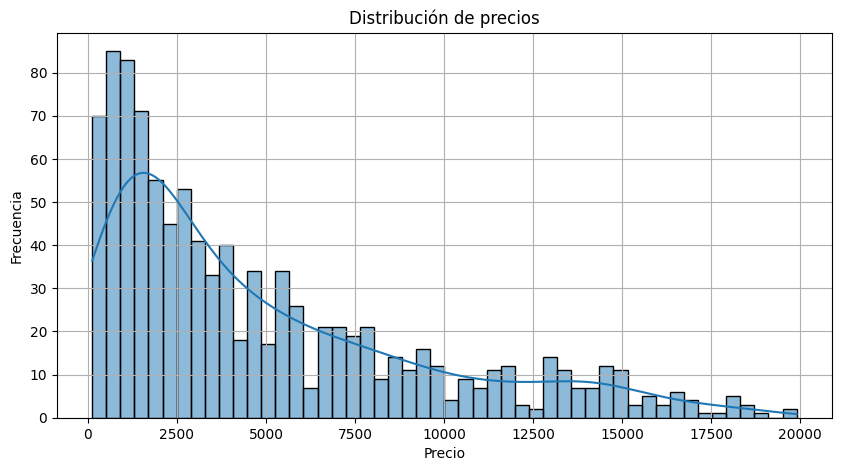

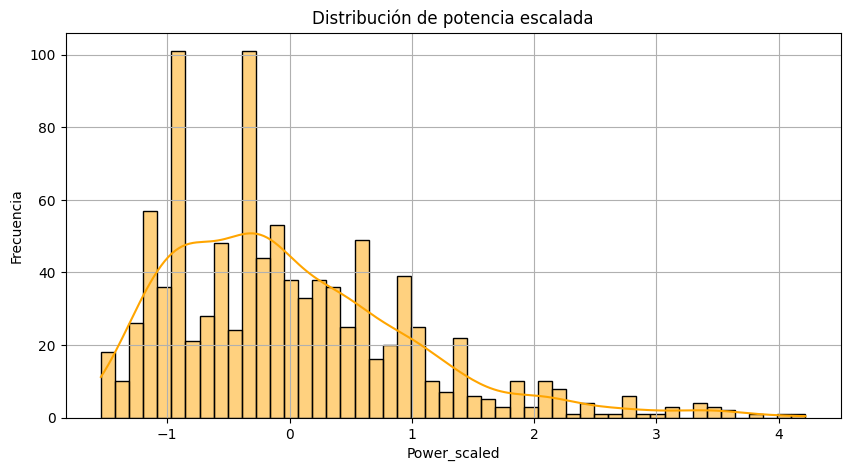

In [26]:
# Se convierte a Pandas para visualización si el dataset es manejable
df_pd = df_final.limit(1000).toPandas()

# Se grafican distribuciones de precios y potencias escaladas
plt.figure(figsize=(10, 5))
sns.histplot(df_pd["Price"], bins=50, kde=True)
plt.title("Distribución de precios")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_pd["Power_scaled"], bins=50, kde=True, color="orange")
plt.title("Distribución de potencia escalada")
plt.xlabel("Power_scaled")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


In [ ]:
# Se convierte el DataFrame de Spark a pandas
df_pd = df_final.toPandas()


In [36]:
df_pd

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,Price,RegistrationYear_scaled,Power_scaled,Mileage_scaled,RegistrationMonth_scaled
0,coupe,manual,unknown,gasoline,audi,yes,18300.0,1.197592,1.309207,-0.105621,-0.274664
1,suv,auto,grand,gasoline,jeep,unknown,9800.0,0.027175,0.799272,-0.105621,0.559641
2,small,manual,golf,petrol,volkswagen,no,1500.0,-0.474432,-0.862739,0.583628,0.003437
3,small,manual,fabia,gasoline,skoda,no,3600.0,0.695985,-0.976058,-1.070569,0.281539
4,sedan,manual,3er,petrol,bmw,yes,650.0,-1.477646,-0.352804,0.583628,1.115844
...,...,...,...,...,...,...,...,...,...,...,...
297806,unknown,auto,159,unknown,alfa_romeo,no,5250.0,2.033603,0.553748,0.583628,1.672047
297807,sedan,manual,leon,petrol,seat,yes,3200.0,0.027175,1.970234,0.583628,-0.274664
297808,convertible,auto,fortwo,petrol,smart,no,1199.0,-0.641634,-0.371690,-0.105621,-0.830867
297809,bus,manual,transporter,gasoline,volkswagen,no,9200.0,-1.310443,-0.352804,0.583628,-0.830867
